In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy.stats import itemfreq
import random
import os.path

import theano
import lasagne
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.externals import joblib
from sklearn.svm import SVC

from nolearn.lasagne import visualize

# import user defined load_data to build input data
from load_data import Data
from utils import save_network
from model_predictions import build_cnn
from model_predictions import generate_features
from model_predictions import extract_features

# Enter your own file path here, in the path it should contain two 
# directories, data and word2vec
FILE_PATH = '/home/sam/Hhd/twitter_sentiment/'
# FILE_PATH = '/home/sam/Data/twitter_sentiment/'

### Use Airline data

In [2]:
airline_data = Data('Airline-Sentiment-2-w-AA.csv', FILE_PATH)
airline_df = airline_data.csv_df(['airline_sentiment', 'text']) # load data
airline_data.pre_process(airline_df) # pre-process data
# drop neutral
# airline_df = airline_data.drop_value(airline_df, 'airline_sentiment', 'neutral')
airline_df.head()

Loading csv: Airline-Sentiment-2-w-AA.csv ...
Note: pre-process changes the dataframe inplace.


,airline_sentiment,text,tokenized
0,neutral,What said,[said]
1,positive,plus youve added commercials to the experienc...,"[plus, youve, added, commercials, experience, ..."
2,neutral,I didnt today Must mean I need to take anothe...,"[didnt, today, must, mean, need, take, another..."
3,negative,its really aggressive to blast obnoxious ente...,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,and its a really big bad thing about it,"[really, big, bad, thing]"


In [3]:
# convert categorical value to int class
# class_label = {'positive': 1, 'negative': 2}
class_label = {'positive': 1, 'neutral': 2, 'negative': 3}

airline_df = airline_data.cat2num(airline_df, 'airline_sentiment', class_label, 'class')
airline_df.head()

class
Done converting categorical to numeric, this changes df.


,text,tokenized,class
0,What said,[said],2
1,plus youve added commercials to the experienc...,"[plus, youve, added, commercials, experience, ...",1
2,I didnt today Must mean I need to take anothe...,"[didnt, today, must, mean, need, take, another...",2
3,its really aggressive to blast obnoxious ente...,"[really, aggressive, blast, obnoxious, enterta...",3
4,and its a really big bad thing about it,"[really, big, bad, thing]",3


In [4]:
# lets take a look of the 
airline_df['class'].value_counts()

3    9178
2    3099
1    2363
Name: class, dtype: int64

In [5]:
# comment out if do not want class balance
airline_df = airline_data.balance_class(airline_df)
# and check again
airline_df['class'].value_counts()

3    3099
2    3099
1    2363
Name: class, dtype: int64

In [6]:
airline_df.head()

,text,tokenized,class
0,What said,[said],2
1,plus youve added commercials to the experienc...,"[plus, youve, added, commercials, experience, ...",1
2,I didnt today Must mean I need to take anothe...,"[didnt, today, must, mean, need, take, another...",2
3,seriously would pay a flight for seats that ...,"[seriously, would, pay, flight, seats, didnt, ...",3
4,yes nearly every time I fly VX this ear worm ...,"[yes, nearly, every, time, fly, vx, ear, worm,...",1


In [7]:
# train or load the model
model = airline_data.build_wordvec(size=600, verbose=False)

Loading existing model tweets600.model.bin ...
Done building.


In [8]:
# max_len is the max length of a sentence in our data, this decides the padding
max_len = airline_data.max_len(airline_df)
# convert our aline data to vector
data = airline_data.convert2vec(airline_df, max_len, model, name='airline-3class-600')
#data = airline_data.standarize(data)
airline_data.save_vec(data, name='airline-3class-600')

max sentence length is:  19
npy already exists, loading ...
Done loading npy file.
npy already exists.


In [9]:
# you can uncomment this to check if the wordvec makes sense
# model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

### create data that gets fed into classifier

In [10]:
N, M, D = data.shape
print "N, M, D:", N, M, D
data = data.reshape(-1, 1, M, D).astype(theano.config.floatX) # theano needs this way
label = airline_df['class']
label = np.int8(label) - 1# seems like theano also needs this
print data.shape
print label.shape

N, M, D: 8561 19 600
(8561, 1, 19, 600)
(8561,)


In [11]:
# train our model or load model if it exists
def train_cnn(net, X_train, y_train, model_name='nn_cnn'):
    model_file = FILE_PATH+'nn_cnn'
    if os.path.isfile(model_file):
        print ("Loading existing model ...")
        net.load_params_from(model_file)
    else:
        # Train the network
        net.fit(X_train, y_train)
        net.save_params_to(model_file)

In [12]:
# initialize
cnn= build_cnn(M, D)
# train
train_cnn(cnn, data, label)

Loading existing model ...
Loaded parameters to layer 'conv2d1' (shape 50x1x3x3).
Loaded parameters to layer 'conv2d1' (shape 50x19x600).
Loaded parameters to layer 'conv2d2' (shape 50x50x3x3).
Loaded parameters to layer 'conv2d2' (shape 50x9x300).
Loaded parameters to layer 'dense' (shape 30000x5000).
Loaded parameters to layer 'dense' (shape 5000).
Loaded parameters to layer 'output' (shape 5000x3).
Loaded parameters to layer 'output' (shape 3).


<module 'matplotlib.pyplot' from '/usr/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

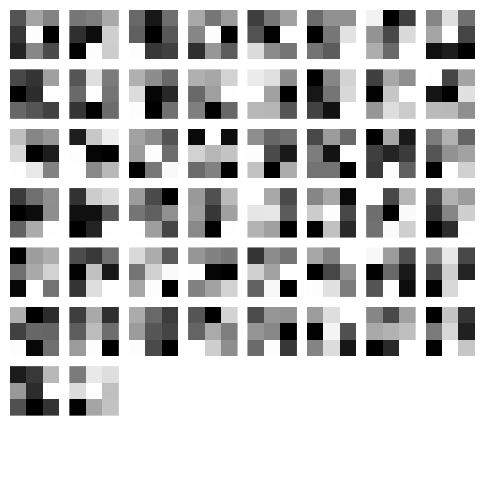

In [13]:
visualize.plot_conv_weights(cnn.layers_['conv2d1'])

In [16]:
# now transfer to svm
# stratified cross-validation
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
n_cv = 1
for train_index, val_index in sss.split(data, label):

    data_train, data_val = data[train_index], data[val_index]
    label_train, label_val = label[train_index], label[val_index]
    
    freq_train = itemfreq(label_train)
    print "train freq", freq_train[:,1]
    freq_val = itemfreq(label_val)
    print "val freq", freq_val[:,1]

    # pass through cnn
    extract_train = extract_features(cnn, data_train)
    extract_val = extract_features(cnn, data_val)
    clf = SVC(verbose=True, random_state=None)
    print "Training cv {} ...".format(n_cv)
    clf.fit(extract_train, label_train)
    acc = clf.score(extract_val, label_val)
    print acc
    print "\n"
    n_cv += 1

train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 1 ...
[LibSVM]0.725627553999


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 2 ...
[LibSVM]0.72270869819


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 3 ...
[LibSVM]0.72270869819


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 4 ...
[LibSVM]0.712784588441


train freq [1890 2479 2479]
val freq [473 620 620]
Extracting ... 
Extracting ... 
Training cv 5 ...
[LibSVM]0.737886748395




In [17]:
# save model
joblib.dump(clf, FILE_PATH+'svm-final.pkl')

['/home/sam/Hhd/twitter_sentiment/svm-final.pkl']